Best solution cost: 552.6382926197846

--- L1 Routes (Trucks):
Truck 0: [0, 1, 1, 22]
Truck 1: [0, 2, np.int64(6), np.int64(8), np.int64(13), np.int64(14), np.int64(16), np.int64(19), np.int64(21), np.int64(17), np.int64(20), np.int64(18), np.int64(15), np.int64(12), np.int64(9), np.int64(7), 2, 22]

--- L2 Routes (Vehicles at Satellite):
Satellite 1, Vehicle 1: [1, np.int64(4), np.int64(3), np.int64(11), np.int64(10), 1]
Satellite 2, Vehicle 1: [2, np.int64(5), 2]
Satellite 2, Vehicle 2: [2, 2]


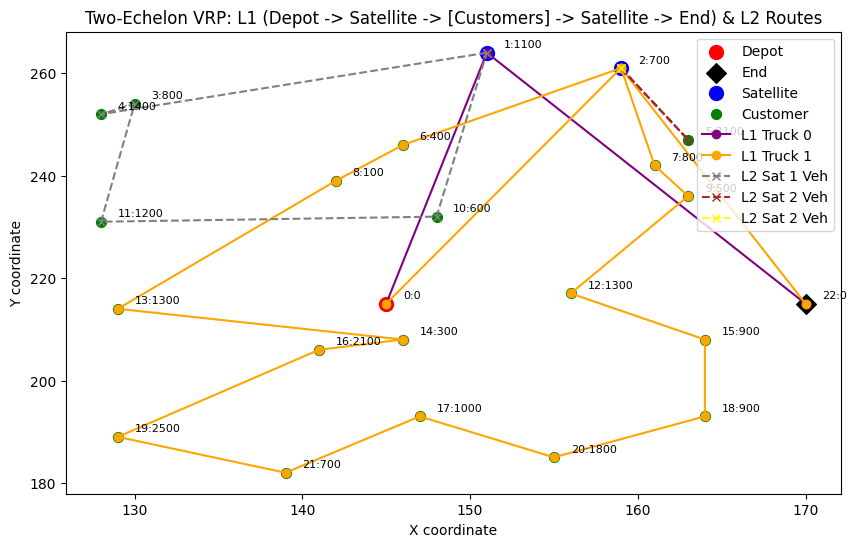

In [2]:
import copy
import numpy as np
import numpy.random as rnd
import matplotlib.pyplot as plt

from alns import ALNS
from alns.accept import RecordToRecordTravel
from alns.select import RouletteWheel
from alns.stop import MaxIterations

# --------------------
# 1. THÔNG SỐ BÀI TOÁN
# --------------------
SEED = 1234
rnd.seed(SEED)

DEPOT = 0       # Điểm xuất phát
END = 22        # Điểm kết thúc
SATELLITES = [1, 2]
CUSTOMERS = list(range(3, 22))

L1_CAPACITY = 15000  # Sức chứa của xe tải tầng 1
L2_CAPACITY = 6000   # Sức chứa của xe tầng 2

L1_FLEET = 2   # Số xe tải tầng 1 (ví dụ 2 xe)
L2_FLEET = 4   # Số xe tầng 2 (chia đều cho các satellite)

# Tọa độ các điểm (bao gồm điểm END)
NODE_COORDS = {
    0: (145, 215),
    1: (151, 264),
    2: (159, 261),
    3: (130, 254),
    4: (128, 252),
    5: (163, 247),
    6: (146, 246),
    7: (161, 242),
    8: (142, 239),
    9: (163, 236),
    10: (148, 232),
    11: (128, 231),
    12: (156, 217),
    13: (129, 214),
    14: (146, 208),
    15: (164, 208),
    16: (141, 206),
    17: (147, 193),
    18: (164, 193),
    19: (129, 189),
    20: (155, 185),
    21: (139, 182),
    22: (170, 215)  # END
}

DEMANDS = {
    0: 0,   1: 1100, 2: 700,
    3: 800, 4: 1400, 5: 2100, 6: 400, 7: 800, 8: 100,
    9: 500, 10: 600, 11: 1200, 12: 1300, 13: 1300, 14: 300, 15: 900,
    16: 2100, 17: 1000, 18: 900, 19: 2500, 20: 1800, 21: 700,
    22: 0
}

def euclidean_distance(a, b):
    x1, y1 = NODE_COORDS[a]
    x2, y2 = NODE_COORDS[b]
    return np.sqrt((x1 - x2)**2 + (y1 - y2)**2)

# Số tuyến xe tầng 2 tối đa cho mỗi satellite (chia đều)
max_routes_sat = {s: L2_FLEET // len(SATELLITES) for s in SATELLITES}

# --------------------
# 2. LỚP TRẠNG THÁI
# --------------------
class TwoEVRPState:
    """
    first_echelon: dict của xe tải tầng 1. Mỗi xe có tuyến dạng:
       [DEPOT, s, ... (khách hàng phục vụ bởi L1) ..., s, END]
       (s xuất hiện 2 lần là cố định: để drop-off/pickup xe L2)
    second_echelon: dict của xe tầng 2 theo satellite, mỗi tuyến có dạng:
       [s] + danh sách khách hàng + [s]
    unassigned: danh sách khách hàng chưa được gán.
    """
    def __init__(self, first_echelon, second_echelon, unassigned=None):
        self.first_echelon = first_echelon
        self.second_echelon = second_echelon
        self.unassigned = unassigned if unassigned is not None else []
    
    def copy(self):
        return TwoEVRPState(copy.deepcopy(self.first_echelon),
                            copy.deepcopy(self.second_echelon),
                            self.unassigned.copy())
    
    def objective(self):
        # Tính tổng quãng đường của xe L1 và L2
        cost_L1 = 0
        for route in self.first_echelon.values():
            cost_L1 += sum(euclidean_distance(route[i], route[i+1]) for i in range(len(route)-1))
        cost_L2 = 0
        for s, routes in self.second_echelon.items():
            for route in routes:
                if route:
                    cost_L2 += euclidean_distance(s, route[0])
                    cost_L2 += sum(euclidean_distance(route[i], route[i+1]) for i in range(len(route)-1))
                    cost_L2 += euclidean_distance(route[-1], s)
        penalty = 1e6 * len(self.unassigned)
        return cost_L1 + cost_L2 + penalty

# --------------------
# 3. GIẢI PHÁP KHỞI TẠO
# --------------------
def initial_solution():
    """
    - Xe L1: Gán mỗi xe cho một satellite (theo vòng lặp). 
      Khởi tạo tuyến L1 với cấu trúc: [DEPOT, s, s, END]
      (Hai lần xuất hiện của s là cố định, cho việc drop-off/pickup xe L2).
    - Xe L2: Mỗi satellite có 1 tuyến rỗng ban đầu; nếu không đủ chỗ thì tạo thêm tuyến mới.
    - Các khách hàng được gán chủ yếu cho L2; nếu không gán được thì đưa vào unassigned.
    """
    first_echelon = {}
    for veh in range(L1_FLEET):
        assigned_sat = SATELLITES[veh % len(SATELLITES)]
        first_echelon[veh] = [DEPOT, assigned_sat, assigned_sat, END]
    
    second_echelon = {s: [[]] for s in SATELLITES}
    route_cap = {s: [L2_CAPACITY] for s in SATELLITES}
    unassigned = []
    
    sorted_customers = sorted(CUSTOMERS, key=lambda c: min(euclidean_distance(c, s) for s in SATELLITES))
    for c in sorted_customers:
        s_best = min(SATELLITES, key=lambda s: euclidean_distance(s, c))
        assigned = False
        for idx, cap in enumerate(route_cap[s_best]):
            if cap >= DEMANDS[c]:
                second_echelon[s_best][idx].append(c)
                route_cap[s_best][idx] -= DEMANDS[c]
                assigned = True
                break
        if not assigned:
            if len(second_echelon[s_best]) < max_routes_sat[s_best]:
                second_echelon[s_best].append([c])
                route_cap[s_best].append(L2_CAPACITY - DEMANDS[c])
                assigned = True
            else:
                unassigned.append(c)
    
    return TwoEVRPState(first_echelon, second_echelon, unassigned)

# --------------------
# 4. TOÁN TỬ DESTROY
# --------------------
def random_removal(state, rng, num_remove=3):
    """
    Loại bỏ ngẫu nhiên một số khách hàng khỏi tuyến L1 và L2 (chỉ loại bỏ các node thuộc CUSTOMERS).
    """
    state = state.copy()
    customers_to_remove = rng.choice(CUSTOMERS, num_remove, replace=False)
    
    # L1: Loại bỏ các khách hàng khỏi tuyến, giữ lại các điểm cố định (DEPOT, END, Satellite)
    for veh, route in state.first_echelon.items():
        new_route = [node for node in route if (node not in customers_to_remove) or (node in [DEPOT, END] or node in SATELLITES)]
        state.first_echelon[veh] = new_route
    
    # L2: Loại bỏ khỏi các tuyến
    for s, routes in state.second_echelon.items():
        for r in routes:
            r[:] = [c for c in r if c not in customers_to_remove]
    
    state.unassigned.extend(customers_to_remove)
    return state

# Hàm tính dung lượng đã sử dụng của xe L1 (chỉ tính các khách hàng)
def used_capacity_L1(route):
    return sum(DEMANDS[c] for c in route if c in CUSTOMERS)

# --------------------
# 5. TOÁN TỬ REPAIR
# --------------------
def greedy_repair(state, rng):
    """
    Với mỗi khách hàng trong unassigned, xét 2 option:
      Option 1: Chèn vào tuyến L1 (xe tải) tại vị trí nằm giữa lần ghé satellite đầu và lần ghé thứ hai.
                Ta duyệt qua tất cả các vị trí khả dĩ giữa index 2 và index (len(route)-2).
                Kiểm tra capacity và tính extra cost.
      Option 2: Chèn vào tuyến L2 của satellite gần nhất (theo cách trước đó).
    Sau đó chèn khách hàng vào vị trí có extra cost nhỏ nhất.
    """
    state = state.copy()
    rng.shuffle(state.unassigned)
    
    for c in state.unassigned:
        best_option = None
        best_extra_cost = float('inf')
        
        # Option 1: Chèn vào L1
        for veh, route in state.first_echelon.items():
            # Giả sử route có dạng: [DEPOT, s, ... , s, END]
            # Các vị trí hợp lệ để chèn là từ index 2 đến index = len(route)-2 (bao gồm cả chèn ở cuối phần khách)
            s = route[1]  # satellite được gán cho xe này
            for pos in range(2, len(route)-1):
                prev_node = route[pos-1]
                next_node = route[pos]
                extra_cost = euclidean_distance(prev_node, c) + euclidean_distance(c, next_node) - euclidean_distance(prev_node, next_node)
                if used_capacity_L1(route) + DEMANDS[c] <= L1_CAPACITY:
                    if extra_cost < best_extra_cost:
                        best_extra_cost = extra_cost
                        best_option = ('L1', veh, pos)
        
        # Option 2: Chèn vào L2 (xe tầng 2)
        for s in SATELLITES:
            for idx, route2 in enumerate(state.second_echelon[s]):
                if len(route2) == 0:
                    extra = euclidean_distance(s, c) + euclidean_distance(c, s)
                    if extra < best_extra_cost:
                        best_extra_cost = extra
                        best_option = ('L2', s, idx, 0)
                else:
                    last = route2[-1]
                    extra = euclidean_distance(last, c) + euclidean_distance(c, s) - euclidean_distance(last, s)
                    if extra < best_extra_cost:
                        best_extra_cost = extra
                        best_option = ('L2', s, idx, len(route2))
        
        if best_option is None:
            # Nếu không có option khả thi (rất hiếm), ta chèn vào L2 của satellite 1
            state.second_echelon[SATELLITES[0]][0].append(c)
        else:
            if best_option[0] == 'L1':
                _, veh, pos = best_option
                state.first_echelon[veh].insert(pos, c)
            else:
                _, s, idx, pos = best_option
                state.second_echelon[s][idx].insert(pos, c)
    
    state.unassigned = []
    return state

# --------------------
# 6. CHẠY ALNS
# --------------------
rng = rnd.default_rng(SEED)
init_state = initial_solution()

alns = ALNS(rng)
alns.add_destroy_operator(random_removal)
alns.add_repair_operator(greedy_repair)

accept = RecordToRecordTravel.autofit(init_state.objective(), 0.02, 0, 10000)
select = RouletteWheel([25, 5, 1, 0], 0.8, 1, 1)
stop = MaxIterations(1000)

result = alns.iterate(init_state, select, accept, stop)
best = result.best_state

print("Best solution cost:", best.objective())
print("\n--- L1 Routes (Trucks):")
for veh, route in best.first_echelon.items():
    print(f"Truck {veh}: {route}")
print("\n--- L2 Routes (Vehicles at Satellite):")
for s, routes in best.second_echelon.items():
    for idx, r in enumerate(routes):
        print(f"Satellite {s}, Vehicle {idx+1}: {[s] + r + [s]}")

# --------------------
# 7. VẼ SƠ ĐỒ
# --------------------
plt.figure(figsize=(10, 6))

# Vẽ các điểm: Depot, End, Satellite, Customer
plt.scatter(NODE_COORDS[DEPOT][0], NODE_COORDS[DEPOT][1], color='red', s=100, label='Depot')
plt.scatter(NODE_COORDS[END][0], NODE_COORDS[END][1], color='black', s=100, marker='D', label='End')
for idx, s in enumerate(SATELLITES):
    plt.scatter(NODE_COORDS[s][0], NODE_COORDS[s][1], color='blue', s=100, label='Satellite' if idx==0 else "")
for idx, c in enumerate(CUSTOMERS):
    plt.scatter(NODE_COORDS[c][0], NODE_COORDS[c][1], color='green', s=50, label='Customer' if idx==0 else "")

# Vẽ tuyến L1 (xe tải)
colors_L1 = ['purple', 'orange', 'magenta', 'cyan']
for veh, route in best.first_echelon.items():
    color = colors_L1[veh % len(colors_L1)]
    xs = [NODE_COORDS[n][0] for n in route]
    ys = [NODE_COORDS[n][1] for n in route]
    plt.plot(xs, ys, color=color, marker='o', label=f'L1 Truck {veh}')

# Vẽ tuyến L2 (xe tầng 2)
colors_L2 = ['gray', 'brown', 'yellow', 'pink']
color_idx = 0
for s, routes in best.second_echelon.items():
    for route in routes:
        full_route = [s] + route + [s]
        color = colors_L2[color_idx % len(colors_L2)]
        xs = [NODE_COORDS[n][0] for n in full_route]
        ys = [NODE_COORDS[n][1] for n in full_route]
        plt.plot(xs, ys, linestyle='--', marker='x', color=color, label=f'L2 Sat {s} Veh')
        color_idx += 1
# Annotate all nodes with their id and demand
for node, coord in NODE_COORDS.items():
    x, y = coord
    # Điều chỉnh vị trí text (offset) nếu cần
    plt.text(x + 1, y + 1, f"{node}:{DEMANDS[node]}", fontsize=8, color='black')


plt.xlabel("X coordinate")
plt.ylabel("Y coordinate")
plt.title("Two-Echelon VRP: L1 (Depot -> Satellite -> [Customers] -> Satellite -> End) & L2 Routes")
plt.legend()
plt.show()